## Dynamic Flux Balance Analysis (dFBA) for MaSp2 using COBRAme

In [1]:
import cobra
#from cobra.io import load_model
import numpy as np
#from tqdm import tqdm
from math import exp
from contextlib import suppress

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/solvers/__init__.py:63: UserWarning: No LP solvers found
  warn("No LP solvers found")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


In [2]:
from __future__ import print_function, division, absolute_import

# python imports
import re
from os.path import join
from collections import defaultdict
import pickle
import pandas as pd

# third party imports
import pandas
import tabulate
import cobra
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',100)
pd.set_option('display.max_colwidth',300)

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
#from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

Create or load a cobrapy model. Here, we use the 'textbook' e-coli core model.

In [3]:
with open('iJL1678b_pET19K_MaSp2_32.pickle', 'rb') as f:
    model = pickle.load(f)

In [4]:
def solve_me_model(model, max_mu, precision=1e-6, min_mu=0, using_soplex=False,
                  compiled_expressions=None):
    if using_soplex:
        from cobrame.solve.algorithms import binary_search
        binary_search(model, min_mu=min_mu, max_mu=max_mu, debug=True, mu_accuracy=precision,
                      compiled_expressions=compiled_expressions)
    else:
        from qminospy.me1 import ME_NLP1
        # The object containing solveME methods--composite that uses a ME model object 
        me_nlp = ME_NLP1(model, growth_key='mu')
        # Use bisection for now (until the NLP formulation is worked out)
        muopt, hs, xopt, cache = me_nlp.bisectmu(precision=precision, mumax=max_mu)
        model.solution.f = model.solution.x_dict['biomass_dilution']
        
def show_escher_map(model, solution=None):
    import escher
    view = escher.Builder("iJO1366.Central metabolism")
    view.reaction_data = model.get_metabolic_flux(solution=solution)
    return view

## Test the model

In [5]:
# Initial uptake values
model.reactions.EX_glc__D_e.lower_bound = -10
model.reactions.EX_ac_e.lower_bound = -10
model.reactions.EX_for_e.lower_bound = -10

model.reactions.get_by_id('DM_protein_MaSp2').lower_bound = 0.00062
model.reactions.get_by_id('DM_protein_MaSp2').upper_bound = 0.00062

# Initial Constants
biomass_0 = 14.1 # Initial biomass (0.035)
biomass_t = biomass_0
time_total = 4 # Hours
samples = 4 # Total number of samples
delta_t = time_total/samples
biomass = []
mu_results = []
solution_results = []
biomass.append(biomass_0)
mu_results.append(0)

# Initialize glucose variables
glc_initial_concentration = 1000000
glc_past_concentration = glc_initial_concentration
glucose_concentration = []
glucose_concentration.append(glc_initial_concentration)

# Initialize acetate variables
ac_initial_concentration = 0
ac_past_concentration = ac_initial_concentration
acetate_concentration = []
acetate_concentration.append(ac_initial_concentration)

# Initialize formate variables
for_initial_concentration = 0
for_past_concentration = for_initial_concentration
formate_concentration = []
formate_concentration.append(for_initial_concentration)

# Initialize MaSp2 variables
MaSp2_initial_concentration = 0
MaSp2_past_concentration = MaSp2_initial_concentration
MaSp2_total_concentration = []
MaSp2_total_concentration.append(MaSp2_initial_concentration)

# Set metabolite t0 concentrations
glc_concentration = glc_initial_concentration
ac_concentration = ac_initial_concentration
for_concentration = for_initial_concentration
MaSp2_concentration = MaSp2_initial_concentration

# Determine timesteps
time = [x*delta_t for x in range(0,samples + 1)]
time_steps = []

for timeStep in time[1:]:
    time_steps.append(timeStep)
    print('\ntimeStep = ', timeStep)
    
    print('DM_protein_MaSp2 Bounds = ', model.reactions.get_by_id('DM_protein_MaSp2').bounds)
    
    with suppress(Exception):
        solve_me_model(model, 1.0, min_mu = .01, precision=1e-2, using_soplex=False)
        solution_results.append(model.solution.f)
    #with suppress(Exception):
        #mu = model.solution.f
    try:
        mu = model.solution.f
    except:
        mu = 0.00001
    if mu <= 0:
        mu = 0.00001
    print('mu = ', mu)
    mu_results.append(mu)
    
    # Calculate accumulated biomass
    biomass.append(biomass_t)
    biomass_t = biomass_0*exp(mu*delta_t);
    biomass_0 = biomass_t
    
    # Calculate glucose concentration in extracellular medium
    try:
        flux_uptake = model.reactions.EX_glc__D_e.x
        #print('Glucose flux = ', model.reactions.EX_glc__D_e.x)
    except:
        flux_uptake = 0
    glc_concentration = glc_past_concentration - (flux_uptake/mu) * biomass_t * (1 - exp(mu*delta_t))
    if glc_concentration <= 0: 
        glc_concentration = 0
        model.reactions.EX_glc__D_e.lower_bound = 0
    glucose_concentration.append(glc_concentration)
    glc_past_concentration = glc_concentration
    
    # Acetate concentration
    try:
        flux_uptake = model.reactions.EX_ac_e.x
    except:
        flux_uptake = 0
    ac_concentration = ac_past_concentration - (flux_uptake/mu) * biomass_t * (1 - exp(mu*delta_t))
    if ac_concentration <= 0: 
        ac_concentration = 0
        model.reactions.EX_ac_e.lower_bound = 0
    acetate_concentration.append(ac_concentration)
    ac_past_concentration = ac_concentration    

    # Formate concentration
    try:
        flux_uptake = model.reactions.EX_for_e.x
    except:
        flux_uptake = 0
    for_concentration = for_past_concentration - (flux_uptake/mu) * biomass_t * (1 - exp(mu*delta_t))
    if for_concentration <= 0: 
        for_concentration = 0
        model.reactions.EX_for_e.lower_bound = 0
    formate_concentration.append(for_concentration)
    for_past_concentration = for_concentration
    
    # MaSp2 concentration
    try:
        flux_uptake = model.reactions.DM_protein_MaSp2.x
    except:
        flux_uptake = 0
    MaSp2_concentration = MaSp2_past_concentration - (flux_uptake/mu) * biomass_t * (1 - exp(mu*delta_t))
    if MaSp2_concentration <= 0: 
        MaSp2_concentration = 0
        #model.reactions.DM_protein_MaSp2.lower_bound = 0
    MaSp2_total_concentration.append(MaSp2_concentration)
    MaSp2_past_concentration = MaSp2_concentration
    
    


timeStep =  1.0
DM_protein_MaSp2 Bounds =  (0.00062, 0.00062)
iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 35.887714 seconds
Finished substituting S,lb,ub in 2.479520 seconds
Finished makeME_LP in 0.399331 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 2.495076 seconds
Finished makeME_LP in 0.385656 seconds
Getting MINOS parameters from ME_NLP...
2 0.5 0.5 0.75 0.75 1
Finished substituting S,lb,ub in 2.500668 seconds
Finished makeME_LP in 0.386548 seconds
Getting MINOS parameters from ME_NLP...
3 0.5 0.5 0.625 0.625 1
Finished substituting S,lb,ub in 2.457657 seconds
Finished makeME_LP in 0.386421 seconds
Getting MINOS parameters from ME_NLP...
4 0.5 0.5 0.5625 0.5625 1
Finished substituting S,lb,ub in 2.448254 seconds
Finished makeME_LP in 0.409353 seconds
Getting MINOS parameters from ME_NLP...
5 0.5 0.5 0.53125 0.53125 1
Finished substituting S,lb,ub in 2.467192 seconds
Finished makeME_LP

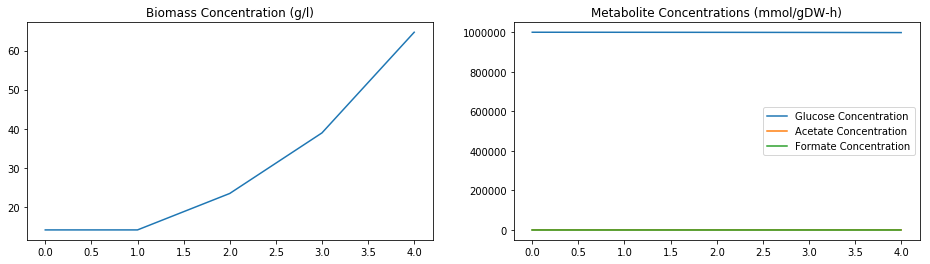

In [6]:
x = time
figure, axis = plt.subplots(1, 2, figsize = (16,4))  
    
# plotting the points 
axis[0].plot(x, biomass)
axis[0].set_title("Biomass Concentration (g/l)")

axis[1].plot(x, glucose_concentration, label = "Glucose Concentration")
axis[1].plot(x, acetate_concentration, label = "Acetate Concentration")
axis[1].plot(x, formate_concentration, label = "Formate Concentration")
axis[1].set_title("Metabolite Concentrations (mmol/gDW-h)")

  
# function to show the plot
plt.legend()
plt.show()

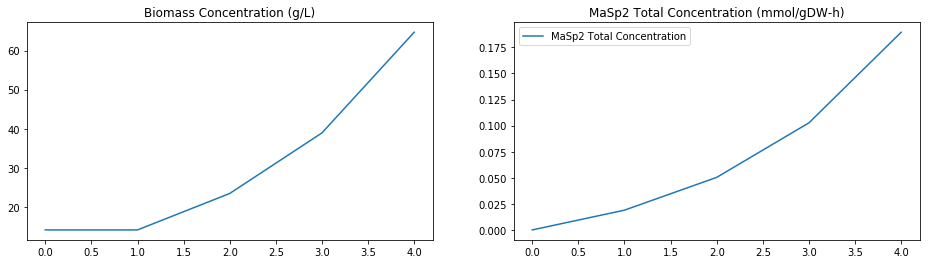

In [7]:
x = time
figure, axis = plt.subplots(1, 2, figsize = (16,4))  
    
# plotting the points 
axis[0].plot(x, biomass)
axis[0].set_title("Biomass Concentration (g/L)")

axis[1].plot(x, MaSp2_total_concentration, label = "MaSp2 Total Concentration")
axis[1].set_title("MaSp2 Total Concentration (mmol/gDW-h)")

  
# function to show the plot
plt.legend()
plt.show()

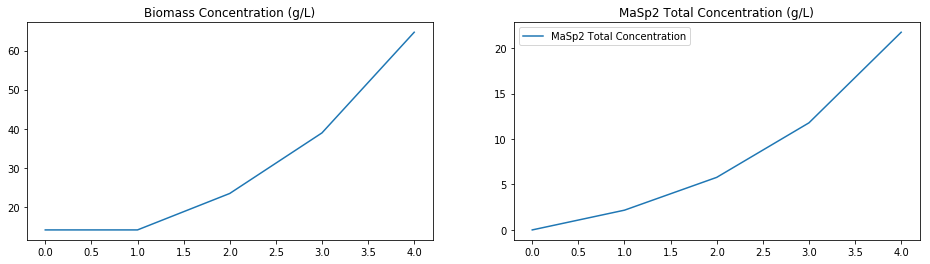

In [8]:
x = time
figure, axis = plt.subplots(1, 2, figsize = (16,4))  

MW = 114.820 # g/mmol
MaSp2_total_concentration_grams = [i * MW for i in MaSp2_total_concentration]
    
# plotting the points 
axis[0].plot(x, biomass)
axis[0].set_title("Biomass Concentration (g/L)")

axis[1].plot(x, MaSp2_total_concentration_grams, label = "MaSp2 Total Concentration")
axis[1].set_title("MaSp2 Total Concentration (g/L)")

  
# function to show the plot
plt.legend()
plt.show()

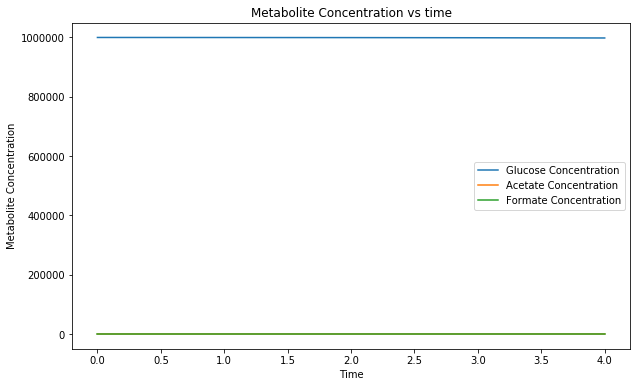

In [9]:
import matplotlib.pyplot as plt

times2 = [x/100 for x in range(0,100,1)]
x = time
y = glucose_concentration

plt.figure(figsize=(10,6))
  
# plotting the points 
plt.plot(x, glucose_concentration, label = "Glucose Concentration")
plt.plot(x, acetate_concentration, label = "Acetate Concentration")
plt.plot(x, formate_concentration, label = "Formate Concentration")
#plt.plot(x, MaSp2_total_concentration, label = "MaSp2 Total Concentration")

# naming the x axis
plt.xlabel('Time')
# naming the y axis
plt.ylabel('Metabolite Concentration')
  
# giving a title to my graph
plt.title('Metabolite Concentration vs time')

# function to show the plot
plt.legend()
plt.show()

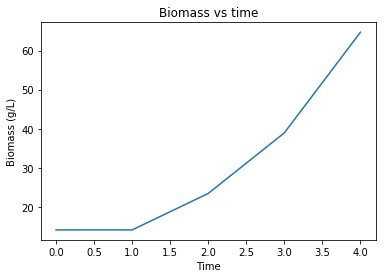

In [10]:
import matplotlib.pyplot as plt

times2 = [x/100 for x in range(0,500,5)]
x = time
y = biomass
  
# plotting the points 
plt.plot(x, y, label = "Time")

# naming the x axis
plt.xlabel('Time')
# naming the y axis
plt.ylabel('Biomass (g/L)')
  
# giving a title to my graph
plt.title('Biomass vs time')
  
# function to show the plot
plt.show()

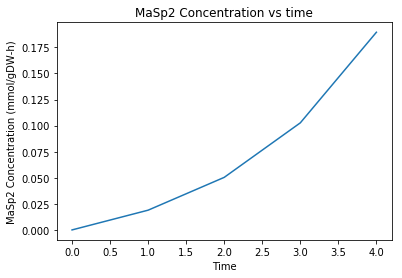

In [11]:
x = time
y = MaSp2_total_concentration
  
# plotting the points 
plt.plot(x, MaSp2_total_concentration, label = "MaSp2 Total Concentration")

# naming the x axis
plt.xlabel('Time')
# naming the y axis
plt.ylabel('MaSp2 Concentration (mmol/gDW-h)')
  
# giving a title to my graph
plt.title('MaSp2 Concentration vs time')
  
# function to show the plot
plt.show()

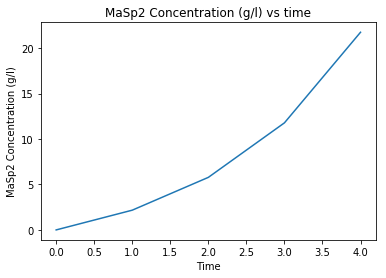

In [12]:
x = time
y = MaSp2_total_concentration
MW = 114.820 # g/mmol
MaSp2_total_concentration_grams = [i * MW for i in MaSp2_total_concentration]
  
# plotting the points 
plt.plot(x, MaSp2_total_concentration_grams, label = "MaSp2 Total Concentration (g/l)")

# naming the x axis
plt.xlabel('Time')
# naming the y axis
plt.ylabel('MaSp2 Concentration (g/l)')
  
# giving a title to my graph
plt.title('MaSp2 Concentration (g/l) vs time')
  
# function to show the plot
plt.show()

In [13]:
MaSp2_total_concentration_grams

[0.0,
 2.173176423830728,
 5.784240139566537,
 11.784572655652855,
 21.75503929314514]

In [14]:
len(biomass)

5

In [15]:
len(time)

5

In [16]:
len(mu_results)

5

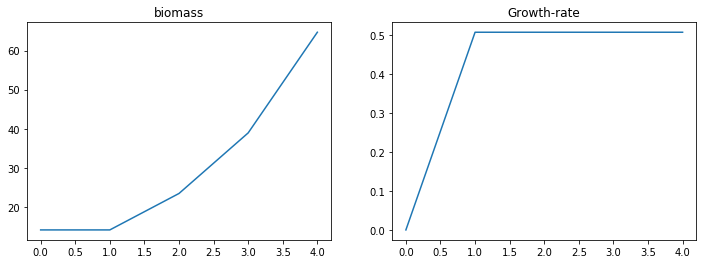

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import math

x = time
y1 = biomass
y2 = mu_results

figure, axis = plt.subplots(1, 2, figsize = (12,4))  
    
# plotting the points 
axis[0].plot(x, biomass)
axis[0].set_title("biomass")

axis[1].plot(x, mu_results)
axis[1].set_title("Growth-rate")

# naming the x axis
#plt.xlabel('Time')
# naming the y axis
#plt.ylabel('Biomass')
  
# giving a title to my graph
#plt.title('Biomass vs time')
  
# function to show the plot
plt.show()

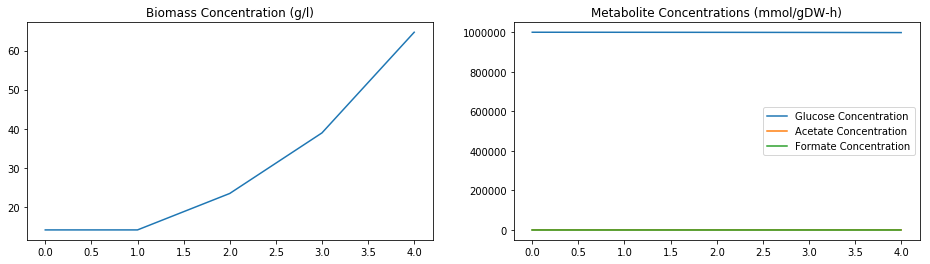

In [18]:
x = time
y1 = biomass
y2 = mu_results

figure, axis = plt.subplots(1, 2, figsize = (16,4))  
    
# plotting the points 
axis[0].plot(x, biomass)
axis[0].set_title("Biomass Concentration (g/l)")

axis[1].plot(x, glucose_concentration, label = "Glucose Concentration")
axis[1].plot(x, acetate_concentration, label = "Acetate Concentration")
axis[1].plot(x, formate_concentration, label = "Formate Concentration")
axis[1].set_title("Metabolite Concentrations (mmol/gDW-h)")

# naming the x axis
#plt.xlabel('Time')
# naming the y axis
#plt.ylabel('Biomass')
  
# giving a title to my graph
#plt.title('Biomass vs time')
  
# function to show the plot
plt.legend()
plt.show()

In [19]:
y2

[0, 0.5078125, 0.5078125, 0.5078125, 0.5078125]